## Sentiment Analysis of Polygon's News API

In [70]:
# Import libraries
import alpaca_trade_api as tradeapi
from helper_functions import *
from cam_paper_keys import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import nltk
nltk.download('vader_lexicon', quiet=True)
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import bs4 as bs
import requests
from datetime import timedelta

In [2]:
# Connect to my 
api = connect_paper_api(paper_key_id, paper_secret_key)
symbols = save_sp500_tickers()
sia = SentimentIntensityAnalyzer()

In [45]:
score_dict = dict()

# Create timestamps for today and yesterday to match with Polygon's news
todays_date = str(pd.Timestamp.today())[0:10]
yesterdays_date = str(pd.Timestamp.today() - timedelta(1))[0:10]

for sym in symbols:
    # If there are news article from today or yesterday in the first few articles...
    for news in api.polygon.news(sym)[0:5]:
        if (news.timestamp[0:10] == todays_date) or (news.timestamp[0:10] == yesterdays_date):
            
            # Try and pull in the summary...
            try:
                soup = bs.BeautifulSoup(resp.text, 'html.parser')
                summary = soup.find('div', {'class': 'a-sum'})
                string = []
                [string.append(blurb.text) for blurb in summary.findAll('p')]
                string = ' '.join(string)
                
                # For each summary, calculate its corresponding sentiment score and today's percent change
                score_dict[sym] = {}
                score_dict[sym]['summary'] = string
                score_dict[sym]['sentiment_score'] = sia.polarity_scores(string)['compound']
                polygon_api = 'https://api.polygon.io/v2/snapshot/locale/us/markets/stocks/tickers/{sym}?apiKey={key}'.format(sym=sym, key=paper_key_id)
                score_dict[sym]['todays_change_pct'] = requests.get(polygon_api).json()['ticker']['todaysChangePerc']
            except:
                pass
        else:
            pass 
        
# Save all the news to a dataframe
df = pd.DataFrame.from_dict(score_dict, orient='index')

In [60]:
df.head()

,summary,sentiment_score,todays_change_pct
AAPL,Apple's iPhone battery replacement cost the co...,0.1388,-0.240
ABBV,Humira had to be discounted by over 80% overse...,-0.7798,0.410
AKAM,Q4 results are out and Akamai beats expectatio...,0.9287,-0.805
AMZN,Amazon is pulling out of its planned secondary...,-0.8720,-0.852
APC,Anadarko Petroleum has posted a 74% increase i...,0.7430,2.705


Now that we have the news, sentiment score, and the percent change for the day all associated with one day - lets see how correlated they all are

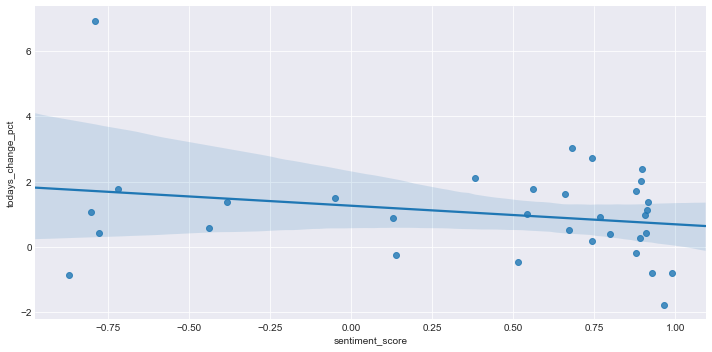

In [83]:
ax = sns.lmplot('sentiment_score', 'todays_change_pct', df, size=5, aspect=2)
plt.show()

Safe to say this sentiment analysis model is real crummy. According to this graph there a negative correlation between a positive sentiment score and a positive return - which makes zero sense. Ethier there's no correlation (doubtful), we need better news (maybe), or most likely this out-of-the-box sentiment analyzer is to vague and not accurate. 

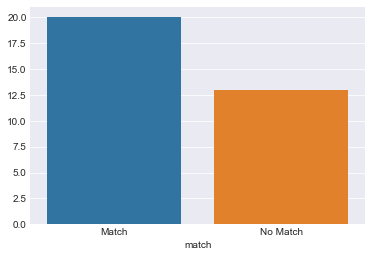

In [97]:
def match(columns):
    if (columns[0] > 0 and columns[1] > 0) or (columns[0] < 0 and columns[1] < 0):
        return 'Match'
    else:
        return 'No Match'

df['match'] = df[['sentiment_score', 'todays_change_pct']].apply(match, axis=1)
sns.barplot(df.groupby('match').count()['sentiment_score'].index, df.groupby('match').count()['sentiment_score'].values)
plt.show()

We can see though that more often than not, a positive score corresponds with a an increase in price and vice versa. Which is why I'm convinced it is the sentiment analyzer that is the problem and not our theory of news/price correlation